<h1>Spectrogram - Jupyter Notebook</h1>

In [1]:
import numpy as np 
from scipy.signal import get_window
from scipy.fft import fft , ifft
import math
import matplotlib.pyplot as plt
from playsound import playsound
from scipy.io.wavfile import write, read
from matplotlib import cm

In [2]:
(fs, x)=read('piano.wav')
INT16_FAC = (2**15)-1
INT32_FAC = (2**31)-1
INT64_FAC = (2**63)-1
norm_fact = {'int16':INT16_FAC, 'int32':INT32_FAC, 'int64':INT64_FAC,'float32':1.0,'float64':1.0}

x = np.float32(x)/norm_fact[x.dtype.name]

In [3]:
M=801  #velicina prozora
N=1024 #N semplova za FFt
H=400  #broj hopova 
w=get_window('hamming', M) #Izabrali smo Hamingov prozor

Funkcija dftAnalysis(x, w, N) vraca magnitudni i fazni spektar signala. Nad  ulaznim signalom x vrsi se FFT.

In [7]:
def dftAnalysis(x, w, N):

    hN = (N//2)                                             # pozitivni deo spektra(sa 0. sample-om)
    hM1 = int(floor((w.size+1)//2))                                     # polovina prozora
    hM2 = int(floor(w.size//2))                                       
    fftbuffer = np.zeros(N)                                 #  fft bafer
    w = w / sum(w)                                          # normalize analysis window
    xw = x*w                                                # window the input sound
    fftbuffer[:hM1] = xw[hM2:]                              # obrnemo
    fftbuffer[-hM2:] = xw[:hM2]        
    X = fft(fftbuffer)                                      # FFT
    absX = abs(X[:hN])                                      # apsolutna vrednost jedne strane
    absX[absX<np.finfo(float).eps] = np.finfo(float).eps    # odstrani nule-postavi na male vrednosti
    mX = 20 * np.log10(absX)                                # magnitude spectrum u decibelima
                       
    X[:hN].real[np.abs(X[:hN].real) < 1e-14] = 0.0            # male vrednosti se postavljaju na 0
    X[:hN].imag[np.abs(X[:hN].imag) < 1e-14] = 0.0                   
    pX = np.unwrap(np.angle(X[:hN]))                        # phase spectrum pozitivnih frekvencijja
    return mX, pX

Funkcija dftSyn(mX, pX, M) vraca originalni signal vrseci IFFT nad spektrom mX

In [8]:
def dftSyn(mX, pX, M):
    """
    Synthesis of a signal using the discrete Fourier transform
    mX: magnitude spectrum, pX: phase spectrum, M: window size
    returns y: output signal
    """

    hN = mX.size                                            # pozitivni deo spektra(sa 0. sample-om)
    N = (hN-1)*2                                            # FFT size

    hM1 = int(math.floor((M+1)/2))                          
    hM2 = int(math.floor(M/2))                              
    fftbuffer = np.zeros(N)                                 
    y = np.zeros(M)                                         # iinicijalizovanje izlaznog niza
    Y = np.zeros(N, dtype = complex)                        
    Y[:hN] = 10**(mX/20) * np.exp(1j*pX)                    # pozitivne frekvencije
    Y[hN:] = 10**(mX[-2:0:-1]/20) * np.exp(-1j*pX[-2:0:-1]) # negativne frekvencije
    fftbuffer = np.real(ifft(Y))                            # ifft
    y[:hM2] = fftbuffer[-hM2:]                              # undo zero-phase window
    y[hM2:] = fftbuffer[:hM1]
    return y

In [9]:
def stft(x, fs, w, N, H) :
    M=w.size
    hM1=int(math.floor((M+1)/2))
    hM2=int(math.floor(M/2))
    x=np.append(np.zeros(hM2), x)
    x=np.append(x, np.zeros(hM2))
    pin=hM1 
    pend=x.size-hM1
    w=w/sum(w)
    y=np.zeros(x.size)
    while pin<=pend :
        x1=x[pin-hM1:pin+hM2]
        mX, pX=dftAnalysis(x1, w, N)
        
        y1=dftSyn(mX, pX, M)
        y[pin-hM1:pin+hM2] += H*y1
        pin+=H
    y=np.delete(y, range(hM2))
    y=np.delete(y, range(y.size-hM1, y.size))
    
    return y

Funkcija stftAnalysis(x, fs, w, N, H) vraca spektar ulaznog signala
Racuna  STFT nad ulaznim signalom, poziva funkciju dftAnalysis koja racuna FFT odredjenog vremenskog prozora

In [10]:
def stftAnalysis(x, fs, w, N, H) :


	if (H <= 0):                                   
		raise ValueError("Hop je <=0!")
		
	M = w.size                                      
	hM1 = (M+1)//2                                 
	hM2 = M//2                                      
	x = np.append(np.zeros(hM2),x)                  # dodavanje nula
	x = np.append(x,np.zeros(hM2))                  # add zeros at the end to analyze last sample
	pin = hM1                                       # initialize sound pointer in middle of analysis window       
	pend = x.size-hM1                               # last sample to start a frame
	w = w / sum(w)                                  # normalize analysis window
	xmX = []                                       # Initialise empty list for mX
	xpX = []                                       # Initialise empty list for pX
	while pin<=pend:                                # while sound pointer is smaller than last sample      
		x1 = x[pin-hM1:pin+hM2]                     # select one frame of input sound
		mX, pX = dftAnalysis(x1, w, N)              # compute dft
		xmX.append(np.array(mX))                    # Append output to list
		xpX.append(np.array(pX))
		pin += H                                    # advance sound pointer
	xmX = np.array(xmX)                             # Convert to numpy array
	xpX = np.array(xpX)
	return xmX, xpX

**stftSyn(mY, pY, M, H)** za sve frejmove poziva dftSyn i vraca originalan signal

In [11]:
def stftSyn(mY, pY, M, H) :
	"""
	Synthesis of a sound using the short-time Fourier transform
	mY: magnitude spectra, pY: phase spectra, M: window size, H: hop-size
	returns y: output sound
	"""
	hM1 = (M+1)//2                                   # half analysis window size by rounding
	hM2 = M//2                                       # half analysis window size by floor
	nFrames = mY[:,0].size                           # number of frames
	y = np.zeros(nFrames*H + hM1 + hM2)              # initialize output array
	pin = hM1                  
	for i in range(nFrames):                         # iterate over all frames      
		y1 = dftSyn(mY[i,:], pY[i,:], M)       # compute idft
		y[pin-hM1:pin+hM2] += H*y1                   # overlap-add to generate output sound
		pin += H                                     # advance sound pointer
	y = np.delete(y, range(hM2))                     # delete half of first window which was added in stftAnal
	y = np.delete(y, range(y.size-hM1, y.size))      # delete the end of the sound that was added in stftAnal
	return y

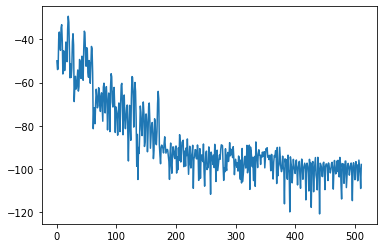

In [12]:

mX, pX= stftAnalysis(x, fs, w, N, H)
y= stftSyn(mX, pX, N, H)
plt.plot(mX[50,:])

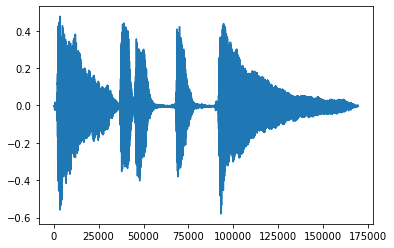

In [13]:
plt.plot(y)

**pcolormesh** funkcija prikazuje 2d spectrogram ulaznog signala

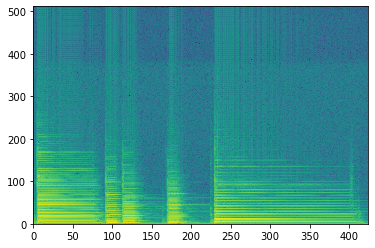

In [15]:
plt.pcolormesh(np.transpose(mX)) 


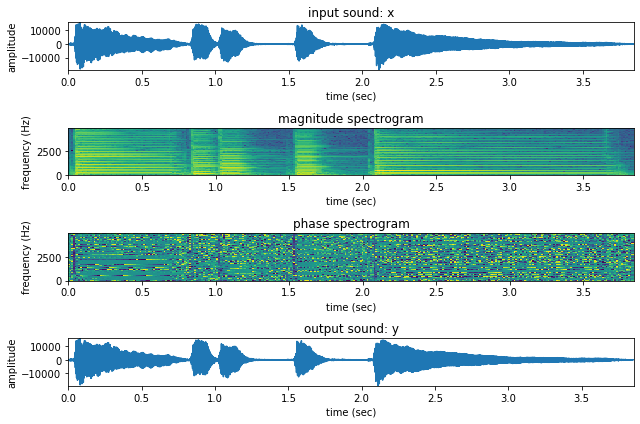

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from scipy.signal import get_window

def main(inputFile = 'piano.wav', window = 'hamming', M = 1024, N = 1024, H = 512):

    fs, x = read(inputFile)
    
    w = get_window(window, M)

    mX, pX = stftAnalysis(x, fs, w, N, H)

    #inverse stft
    y = stftSyn(mX, pX, M, H)

    outputFile = (inputFile) + '_stft.wav'
    
    # write the sound resulting from the inverse stft
    write(outputFile, fs, y)

    plt.figure(figsize=(9, 6))

    maxplotfreq = 5000.0

	# input sound
	plt.subplot(4,1,1)
	plt.plot(np.arange(x.size)/float(fs), x)
	plt.axis([0, x.size/float(fs), min(x), max(x)])
	plt.ylabel('amplitude')
	plt.xlabel('time (sec)')
	plt.title('input sound: x')

	# plot magnitude spectrogram
	plt.subplot(4,1,2)
	numFrames = int(mX[:,0].size)
	frmTime = H*np.arange(numFrames)/float(fs)
	binFreq = fs*np.arange(N*maxplotfreq/fs)/N
	plt.pcolormesh(frmTime, binFreq, np.transpose(mX[:,:int(N*maxplotfreq/fs+1)]))
	plt.xlabel('time (sec)')
	plt.ylabel('frequency (Hz)')
	plt.title('magnitude spectrogram')
	plt.autoscale(tight=True)

	# fazni spect.
	plt.subplot(4,1,3)
	numFrames = int(pX[:,0].size)
	frmTime = H*np.arange(numFrames)/float(fs)
	binFreq = fs*np.arange(N*maxplotfreq/fs)/N
	plt.pcolormesh(frmTime, binFreq, np.transpose(np.diff(pX[:,:int(N*maxplotfreq/fs+1)],axis=1)))
	plt.xlabel('time (sec)')
	plt.ylabel('frequency (Hz)')
	plt.title('phase spectrogram')
	plt.autoscale(tight=True)

	# output sound
	plt.subplot(4,1,4)
	plt.plot(np.arange(y.size)/float(fs), y)
	plt.axis([0, y.size/float(fs), min(y), max(y)])
	plt.ylabel('amplitude')
	plt.xlabel('time (sec)')
	plt.title('output sound: y')

	plt.tight_layout()
	plt.ion()
	plt.show()


if __name__ == "__main__":
	main()

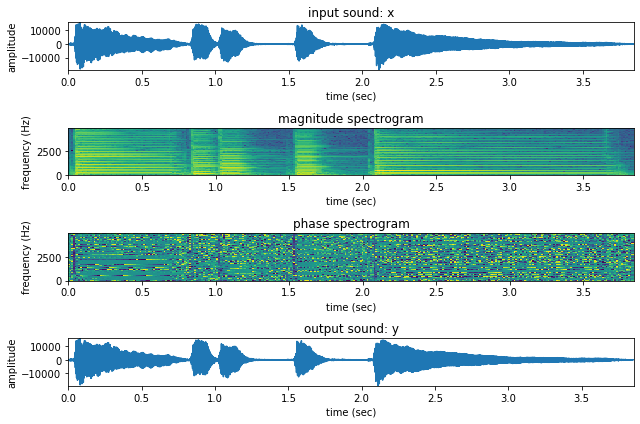

Funkcija **waterfall_plot** predstavlja STTFT spektrogram u 3D prostoru. 
Mapira vrednosti rezultujuceg magnitude spektra sa odgovarjucim bojama.

In [36]:
def waterfall_plot(fig,ax,X,Y,Z,**kwargs):
    '''
        kwargs : kwargs are directly passed to the LineCollection object
    '''
    # Set normalization to the same values for all plots
    norm = plt.Normalize(Z.min().min(), Z.max().max())
    # Check sizes to loop always over the smallest dimension
    n,m = Z.shape
    if n>m:
        X=X.T; Y=Y.T; Z=Z.T
        m,n = n,m

    for j in range(n):
        # reshape the X,Z into pairs 
        points = np.array([X[j,:], Z[j,:]]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)  
        # The values used by the colormap are the input to the array parameter
        lc = LineCollection(segments, cmap='plasma', norm=norm, array=(Z[j,1:]+Z[j,:-1])/2, **kwargs)
        line = ax.add_collection3d(lc,zs=(Y[j,1:]+Y[j,:-1])/2, zdir='y') # add line to axes

    fig.colorbar(lc) # add colorbar, as the normalization is the same for all
    # it doesent matter which of the lc objects we use
    ax.auto_scale_xyz(X,Y,Z) # set axis limits

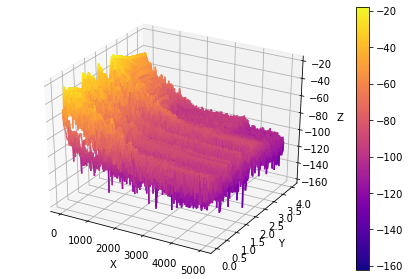

In [37]:
import numpy as np; import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D

# Generate data
# x = np.arange(424)
# y = np.arange(512)
x=np.linspace(0,4,424)
y=np.linspace(0,5000,512)
X,Y = np.meshgrid(y, x)
# Z = np.sin(X**2+Y**2)-.2*X
# Generate waterfall plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,X,Y,mX) 
ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z') 
fig.tight_layout()